# AI6126 ACV Project 1


In [1]:
nb_ver = 1.0
title = f'ai6126-project1-colab-v{nb_ver}'
print(title)
comments = ""
print(comments)

ai6126-project1-colab-v1.0
sche


## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint
+ V0.4 - Added time taken + save output
+ V0.5 - Added RandomErasing to transforms
+ V0.6 - Added get_criterion (FocalLoss) 
+ V0.7 - Added FaceAttrMobileNetV2 & FaceAttrResNeXt
+ V0.8 - Added Albumentations
+ V0.9 - Updated Optimizer
+ V0.91 - Added ModelTimer() + Added more augmentations
+ V1.0 - Updated Scheduler

### References
+ [Face Attribute Prediction on CelebA benchmark with PyTorch Implementation](https://github.com/d-li14/face-attribute-prediction)
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [Albumentations](https://albumentations.ai/)
+ [Focal Loss](https://github.com/kornia/kornia/blob/master/kornia/losses/focal.py)

### Dependencies

In [2]:
# conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
# conda install matplotlib
# conda install pandas
# conda install tqdm
# conda install -c conda-forge jupyterlab
# conda install -c conda-forge tensorboard
# conda install -c conda-forge protobuf # for tensorboard
# conda install nb_conda_kernels # auto add kernels

# conda install -c conda-forge imgaug
# conda install albumentations -c conda-forge

## Setup/ Configuration

### Colab

In [3]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

### Download Dataset (JUPYTER ONLY)

In [4]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [5]:
import sys, os
import shutil
import time
import random
import numpy as np
import copy
from datetime import datetime
from distutils.dir_util import copy_tree #for recursive filecopying

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import matplotlib.pyplot as plt

import config
from celeba_dataset import CelebaDataset
import models
import losses
from utils import Logger, AverageMeter, Bar, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne, ModelTimer

In [6]:
# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

ISJUPYTER = False
if 'ipykernel' in sys.modules:
    ISJUPYTER = True
    # set the backend of matplotlib to the 'inline' backend
    %matplotlib inline
    config.disable_tqdm = False
    
print(f"disable_tqdm: {config.disable_tqdm}")

1.6.0 True
cuda:0
disable_tqdm: False


### Seeding

In [7]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [8]:
# attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
#                    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
#                    'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
#                    'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
#                    'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
#                    'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
#                    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
# print(attribute_names)

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
def load_dataloaders(print_info=True, albu_transforms = True):
    if config.evaluate:
        phases = ['test']
    else:
        phases = ['train', 'val']

    attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
    
    attributes_list = {
        'train': config.TRAIN_ATTRIBUTE_LIST,
        'val': config.VAL_ATTRIBUTE_LIST,
        'test': config.TEST_ATTRIBUTE_LIST
    }

    batch_sizes = {
        'train': config.train_batch,
        'val': config.test_batch,
        'test': config.test_batch
    }

    if not albu_transforms:
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(128), #new
                transforms.CenterCrop(128), #new
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10), #new
                transforms.ToTensor(),
                normalize,
                transforms.RandomErasing()
            ]),
            'val': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ]),
            'test': transforms.Compose([
                transforms.Resize(128), #new
                transforms.ToTensor(),
                normalize
            ])
        }
    else:
        normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                                  std=(0.229, 0.224, 0.225))
        data_transforms = {
            'train': A.Compose([
                A.SmallestMaxSize(max_size=160),
                A.HorizontalFlip(p=0.5),
                A.MotionBlur(p=0.1),
                A.GaussNoise(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                                   rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                #A.CoarseDropout(),
                normalize_A,
                ToTensorV2(),
            ]),
            'val': A.Compose([
                A.SmallestMaxSize(max_size=160),
                #A.CenterCrop(height=148, width=148),
                normalize_A,
                ToTensorV2(),
            ]),
            'test': A.Compose([
                A.SmallestMaxSize(max_size=160),
                #A.CenterCrop(height=148, width=148),
                normalize_A,
                ToTensorV2(),
            ])
        }

    image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                       data_transforms[x]) 
                      for x in phases}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                  batch_size=batch_sizes[x],
                                                  pin_memory=True, shuffle=(x == 'train'), 
                                                  num_workers=config.dl_workers) 
                   for x in phases}
    if print_info:
        dataset_sizes = {x: len(image_datasets[x]) for x in phases}
        print(f"Dataset sizes: {dataset_sizes}")
        
    if config.evaluate:
        class_names = image_datasets['test'].targets
    else:
        class_names = image_datasets['train'].targets
    print(f"Class Labels: {len(class_names[0])}")
    assert len(attribute_names) == len(class_names[0])
    return dataloaders, attribute_names

### Model Architecture Initialization

In [10]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrMobileNetV2', 'FaceAttrResNeXt', 'FaceAttrResNet']


In [11]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[config.arch]()
    #print(model)
    model = model.to(device)
    return model
#print(model)
model = create_model(device)

=> creating model 'FaceAttrResNet'


### Criterion & Optimizer & Scheduler

In [12]:
def get_criterion():
    criterion = nn.CrossEntropyLoss().to(device)
    if config.criterion == 'BinaryFocalLoss':
        criterion = losses.BinaryFocalLoss().to(device)
    elif config.criterion == 'FocalLoss':
        criterion = losses.FocalLoss(alpha=0.25, gamma=5, reduction='mean').to(device)
    return criterion

criterion = get_criterion()

In [13]:
def get_optimizer(model):
    optimizer = torch.optim.SGD(model.parameters(), config.lr,
                            momentum=config.momentum,
                            weight_decay=config.weight_decay)
    if config.optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), config.lr,
                            weight_decay=config.weight_decay)
    elif config.optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), config.lr,
                            weight_decay=config.weight_decay)
    return optimizer

optimizer = get_optimizer(model)

In [14]:
def get_scheduler(optimizer):
    scheduler = None # Manual
    if config.scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                               factor=0.05,
                                                               patience=config.patience)
    return scheduler    

scheduler = get_scheduler(optimizer)
print(scheduler)
print(optimizer.param_groups[0]['lr'])

0.01


### Resume Checkpoint if any

In [15]:
def resume_checkpoint(model, optimizer, ckp_logger_fname, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    lr = config.lr

    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1, lr, total_train_time = model.load_ckp(optimizer, ckp_resume)
        model_timer = ModelTimer(total_train_time)
        if config.scheduler == 'Manual':
            lr = config.lr # self adjust from original
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        model_timer = ModelTimer()
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, model_timer, lr, start_epoch, logger

# best_prec1, mt, lr, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
# print(f"=> Model trained time: {mt}")

## Train & Validate Function

In [16]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(tqdm(train_loader, disable=config.disable_tqdm)):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)): 
            crit = criterion(output[j], y[:, j])
            loss.append(crit)
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
            losses[j].update(loss[j].detach().item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                        batch=i + 1,
                        size=len(train_loader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=loss_avg,
                        top1=prec1_avg,
                        )
        if not config.disable_tqdm and (i+1)% 100 == 0:
            print(print_line)
        bar.suffix  = print_line
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [17]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(tqdm(val_loader, disable=config.disable_tqdm)):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))
                
                losses[j].update(loss[j].detach().item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
            # plot progress
            print_line = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                            batch=i + 1,
                            size=len(val_loader),
                            data=data_time.avg,
                            bt=batch_time.avg,
                            total=bar.elapsed_td,
                            eta=bar.eta_td,
                            loss=loss_avg,
                            top1=prec1_avg,
                            )

            bar.suffix  = print_line
            bar.next()  

    if not config.disable_tqdm:
        print(print_line)        
    bar.finish()
    return (loss_avg, prec1_avg, top1)

## Main Function

In [18]:
def trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name, model_timer, scheduler):
    # visualization
    writer = SummaryWriter(os.path.join(config.tensorboard_dir, run_name))
    
    for epoch in range(start_epoch, config.epochs):
        model_timer.start_epoch_timer()
        if not scheduler:
            lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                     total_epochs=config.epochs, turning_point=config.turning_point,
                                     schedule=config.schedule)
        else:
            lr = optimizer.param_groups[0]['lr']

        print('\nEpoch: [%d | %d] LR: %.16f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1, _ = validate(dataloaders['val'], model, criterion)
        
        if scheduler:
            scheduler.step(val_loss)
            
        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        model_timer.stop_epoch_timer()
        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
            'lr': lr,
            'total_time': model_timer.total_time
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)

    logger.close()
    logger.plot()
    save_path = None
    if config.train_saveplot:
        save_path = os.path.join(config.CHECKPOINT_DIR, run_name+".jpg")
    logger.plot_special(save_path)
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)
    return model_timer

In [19]:
def get_run_name_time(model, criterion, optimizer, comments):
    try:
        if criterion.name:
            p_criterion = criterion.name
    except:
        p_criterion = 'CE'

    p_optimizer = f'{str(optimizer).split("(")[0].strip()}'
    p_scheduler = f'{config.lr_decay}_lr{config.lr}_wd{config.weight_decay}'
    if config.lr_decay == 'step':
        p_scheduler += f'_g{config.gamma}_sp{config.step}'
    elif config.lr_decay == 'linear2exp':
        p_scheduler += f'_g{config.gamma}_tp{config.turning_point}'
    elif config.lr_decay == 'schedule':
        p_scheduler += f'_g{config.gamma}_sch{config.schedule}'

    run_name = f'{model.name}_{config.manual_seed}_s{start_epoch}e{config.epochs}_' \
                + f'tb{config.train_batch}_vb{config.test_batch}_' \
                + f'{p_criterion}_{p_optimizer}_' \
                + f'{comments}_' \
                + f'{p_scheduler}'
    
    run_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(run_name, run_time)
    return run_name, run_time

## Training Loop

=> creating model 'FaceAttrResNet'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40
=> Training model: True
FaceAttrResNet18_42_s0e2_tb256_vb128_CE_AdamW_sche_step_lr0.01_wd0.0001_g0.1_sp30 20201008_143614

Epoch: [1 | 2] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [02:11<07:09,  1.25it/s]

(100/636) Data: 0.791s | Batch: 1.311s | Total: 0:02:11 | ETA: 0:11:23 | Loss: 0.4844 | top1:  79.8148


 31%|█████████████████████████▏                                                      | 200/636 [04:45<11:39,  1.60s/it]

(200/636) Data: 0.974s | Batch: 1.426s | Total: 0:04:45 | ETA: 0:10:36 | Loss: 0.4565 | top1:  80.5870


 47%|█████████████████████████████████████▋                                          | 300/636 [07:10<05:41,  1.02s/it]

(300/636) Data: 0.989s | Batch: 1.436s | Total: 0:07:10 | ETA: 0:07:15 | Loss: 0.4433 | top1:  81.1192


 63%|██████████████████████████████████████████████████▎                             | 400/636 [09:40<07:09,  1.82s/it]

(400/636) Data: 1.018s | Batch: 1.451s | Total: 0:09:40 | ETA: 0:07:18 | Loss: 0.4343 | top1:  81.4525


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [12:05<03:11,  1.41s/it]

(500/636) Data: 1.021s | Batch: 1.450s | Total: 0:12:05 | ETA: 0:03:06 | Loss: 0.4253 | top1:  81.7837


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [14:32<00:55,  1.56s/it]

(600/636) Data: 1.017s | Batch: 1.454s | Total: 0:14:32 | ETA: 0:01:10 | Loss: 0.4167 | top1:  82.1026


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.03it/s]


(156/156) Data: 0.048s | Batch: 0.163s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.3743 | top1:  84.7122
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/636 [00:00<?, ?it/s]


Epoch: [2 | 2] LR: 0.0100000000000000


 16%|████████████▌                                                                   | 100/636 [01:09<05:09,  1.73it/s]

(100/636) Data: 0.117s | Batch: 0.698s | Total: 0:01:09 | ETA: 0:05:12 | Loss: 0.3326 | top1:  85.5467


 31%|█████████████████████████▏                                                      | 200/636 [02:07<04:12,  1.73it/s]

(200/636) Data: 0.059s | Batch: 0.639s | Total: 0:02:07 | ETA: 0:04:14 | Loss: 0.3217 | top1:  86.0145


 47%|█████████████████████████████████████▋                                          | 300/636 [03:05<03:15,  1.72it/s]

(300/636) Data: 0.040s | Batch: 0.619s | Total: 0:03:05 | ETA: 0:03:16 | Loss: 0.3182 | top1:  86.1775


 63%|██████████████████████████████████████████████████▎                             | 400/636 [04:03<02:16,  1.73it/s]

(400/636) Data: 0.030s | Batch: 0.609s | Total: 0:04:03 | ETA: 0:02:17 | Loss: 0.3131 | top1:  86.3705


 79%|██████████████████████████████████████████████████████████████▉                 | 500/636 [05:01<01:18,  1.73it/s]

(500/636) Data: 0.025s | Batch: 0.603s | Total: 0:05:01 | ETA: 0:01:20 | Loss: 0.3073 | top1:  86.5994


 94%|███████████████████████████████████████████████████████████████████████████▍    | 600/636 [05:59<00:20,  1.73it/s]

(600/636) Data: 0.021s | Batch: 0.599s | Total: 0:05:59 | ETA: 0:00:22 | Loss: 0.3014 | top1:  86.8423


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.04it/s]


(156/156) Data: 0.054s | Batch: 0.163s | Total: 0:00:25 | ETA: 0:00:01 | Loss: 0.2796 | top1:  88.5003
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'
=> saving best model 'checkpoints\model_best.pth.tar'


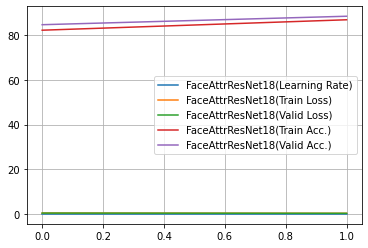

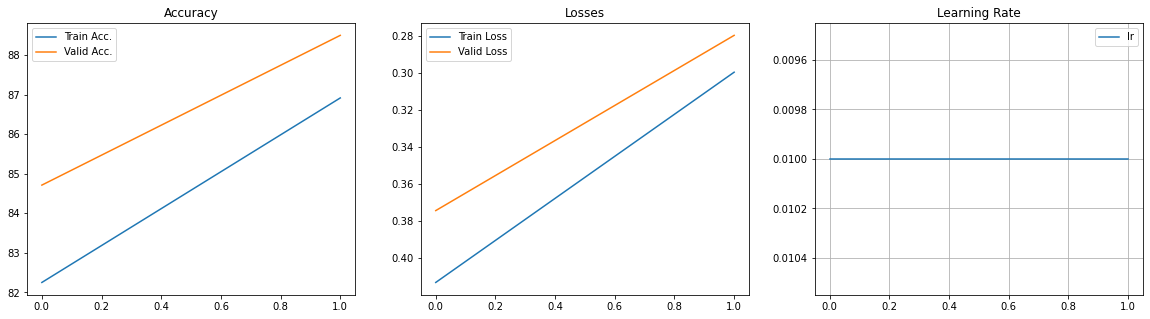

Best accuracy:
88.50027683849648
=> Model trained time: 00:22:38


<Figure size 432x288 with 0 Axes>

In [20]:
# config.epoch = 1
model = create_model(device)
dataloaders, attribute_names  = load_dataloaders()
criterion = get_criterion()
optimizer = get_optimizer(model)
scheduler = get_scheduler(optimizer)

print(f"=> Training model: {not config.evaluate}")
if config.evaluate:
    best_prec1, mtimer, _, _, logger, = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.checkpoint_fname) # checkpoint_fname bestmodel_fname
    #logger.plot_special()
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print_attribute_acc(top1, attribute_names)
else:
    best_prec1, mtimer, lr, start_epoch, logger = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.ckp_resume)
    run_name, run_time = get_run_name_time(model, criterion, optimizer, comments)
    mtimer = trainer(dataloaders, model, criterion, optimizer, logger, start_epoch, best_prec1, run_name, mtimer, scheduler)

print(f"=> Model trained time: {mtimer}")

## Testing Loop

In [21]:
if not config.evaluate:
    config.evaluate = True
    model = create_model(device)
    dataloaders, attribute_names = load_dataloaders()
    criterion = get_criterion()
    optimizer = get_optimizer(model)
    
    best_prec1, mtimer, _, _, _, = resume_checkpoint(model, optimizer, config.ckp_logger_fname, config.bestmodel_fname)# config.bestmodel_fname  config.checkpoint_fname
    #print(model)
    test_loss, prec1, top1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
    print(f"=> Model trained time: {mtimer}")
    print_attribute_acc(top1, attribute_names)

=> creating model 'FaceAttrResNet'
Dataset sizes: {'test': 19962}
Class Labels: 40
=> resuming model: checkpoints\model_best.pth.tar
=> loading checkpoint 'checkpoints\model_best.pth.tar'


  0%|                                                                                          | 0/156 [00:00<?, ?it/s]

=> loaded checkpoint 'checkpoints\model_best.pth.tar' (epoch 2)
=> resuming logger
{'Learning Rate': ['0.010000000000000', '0.010000000000000'], 'Train Loss': ['0.413117088722642', '0.299530105837358'], 'Valid Loss': ['0.374295548944044', '0.279622398702578'], 'Train Acc.': ['82.249708178096569', '86.917106961152285'], 'Valid Acc.': ['84.712211201917810', '88.500276838496475']}


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.59it/s]

(156/156) Data: 0.053s | Batch: 0.176s | Total: 0:00:27 | ETA: 0:00:01 | Loss: 0.2798 | top1:  87.9694
=> Best test accuracy: 87.96939182405706, Model val acc: 88.50027683849648
=> Model trained time: 00:22:38
5_o_Clock_Shadow: 91.65915236431519
Arched_Eyebrows: 75.81404669941003
Attractive: 75.69381823098776
Bags_Under_Eyes: 81.6952208937582
Bald: 97.88598333094477
Bangs: 93.81825467090475
Big_Lips: 68.7957118318812
Big_Nose: 81.37461174247427
Black_Hair: 85.88818752119505
Blond_Hair: 94.33924454556309
Blurry: 94.78509165201358
Brown_Hair: 86.2438633456974
Bushy_Eyebrows: 87.56637611385338
Chubby: 94.67989176306932
Double_Chin: 95.70183344616368
Eyeglasses: 97.95611662769613
Goatee: 96.14768057095958
Gray_Hair: 97.23975550417742
Heavy_Makeup: 86.18374910040258
High_Cheekbones: 82.93758138479468
Male: 94.1138162195366
Mouth_Slightly_Open: 82.70213401648435
Mustache: 96.13265200753379
Narrow_Eyes: 85.13175029962936
No_Beard: 92.80132248143421
Oval_Face: 72.39254581339432
Pale_Skin: 96.5

## Save & Backup

In [22]:
if ISJUPYTER:
    # Wait for notebook to save
    %autosave 1
    time.sleep(150)
    %autosave 120

Autosaving every 1 seconds


Autosaving every 120 seconds


In [23]:
def backup_everything(run_time, run_name, title, backup_nb=ISJUPYTER):
    # backup checkpoints
    print(f"=> backing up checkpoints... ")
    run_dir = os.path.join(config.BACKUP_DIR, run_name, run_time)
    create_dir_ifne(run_dir)
    fromDirectory = config.CHECKPOINT_DIR
    toDirectory = run_dir
    copy_tree(fromDirectory, toDirectory)
    
    if backup_nb:
        print(f"=> backing up notebook... ")
        # backup notebook html
        nb_name = title + '.ipynb'
        html_name = title + '.html'
        save_name = os.path.join(run_dir, html_name)
        !jupyter nbconvert --to html $nb_name
        shutil.move(html_name, save_name)
    
backup_everything(run_time, run_name, title, backup_nb=ISJUPYTER)

=> backing up checkpoints... 
=> backing up notebook... 


[NbConvertApp] Converting notebook ai6126-project1-colab-v1.0.ipynb to html
[NbConvertApp] Writing 768495 bytes to ai6126-project1-colab-v1.0.html


In [24]:
if config.auto_hibernate and False:
    os.system('shutdown -h')